<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/tilted_losses_variational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Syntetic dataset

In [35]:
import numpy as np

In [36]:
true_w = np.array([0.8, -1])
noise_strength = 0.3
n = 100

np.random.seed(42)
x = np.stack([np.random.randn(n), np.ones(n)], axis=-1)
y = x @ true_w + noise_strength * np.random.standard_t(df=3, size=n)

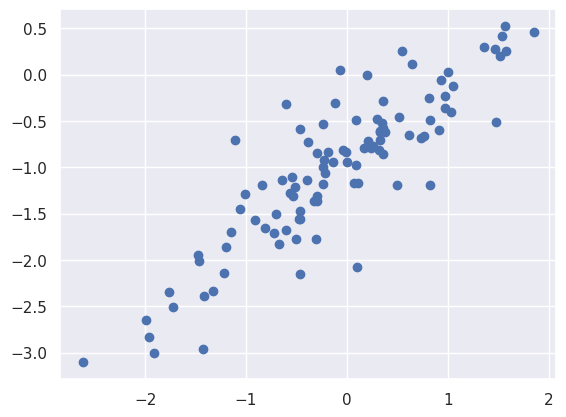

In [37]:
import matplotlib.pyplot as plt

plt.scatter(x[:, 0], y)
plt.show()

## Try stripped reformulation

In [38]:
class StrippedTiltedLoss:
  def __init__(self, underlying_loss, t):
    super().__init__()
    self.underlying_loss = underlying_loss
    self.t = t

  def __call__(self, pred, target):
    return torch.exp(self.t * self.underlying_loss(pred, target))

In [39]:
import torch

def pytorch_fit(x, y, criterion, make_optim_fn, n_epochs=100):
  # convert numpy arrays to torch tensors
  x = torch.as_tensor(x)
  y = torch.as_tensor(y)

  # define initial w to be the zero vector
  w_fit = torch.nn.Parameter(torch.zeros_like(x[0]))

  # create optimizer
  optim = make_optim_fn([w_fit])

  # regular PyTorch training loop.
  for epoch in range(n_epochs):
    for xi, yi in zip(x, y):
      pred = torch.dot(xi, w_fit)
      loss = criterion(pred, yi)

      optim.zero_grad()
      loss.backward()
      optim.step()

  return w_fit.detach()

In [40]:
from torch.nn import MSELoss

pytorch_fit(x, y,
            criterion=StrippedTiltedLoss(MSELoss(), t=1),
            make_optim_fn=lambda params: torch.optim.SGD(params, lr=1e-4))

tensor([nan, nan], dtype=torch.float64)

In [41]:
pytorch_fit(x, y,
            criterion=StrippedTiltedLoss(MSELoss(), t=1),
            make_optim_fn=lambda params: torch.optim.SGD(params, lr=1e-6))

tensor([ 0.4708, -0.3032], dtype=torch.float64)

In [42]:
import math

def compute_tilted_loss(w_fit, x, y, t):
  x = torch.as_tensor(x)
  y = torch.as_tensor(y)
  n = x.shape[0]
  return torch.logsumexp(t * torch.square(x @ w_fit - y) - math.log(n), dim=-1) / t

In [43]:
from tqdm.auto import tqdm
from functools import partial

def eval_sgd_exponential_loss(x, y, lrs, t=1):
  losses = []
  for lr in tqdm(lrs):
      optim_factory = partial(torch.optim.SGD, lr=lr)
      w_exp_fit = pytorch_fit(x, y, StrippedTiltedLoss(MSELoss(), t), optim_factory)
      w_exp_loss = compute_tilted_loss(w_exp_fit, x, y, t).item()
      losses.append(w_exp_loss)

  return losses

In [44]:
lrs = np.geomspace(1e-7, 1e-4, 60).tolist()
losses = eval_sgd_exponential_loss(x, y, lrs)

  0%|          | 0/60 [00:00<?, ?it/s]

(1e-07, 0.0001)

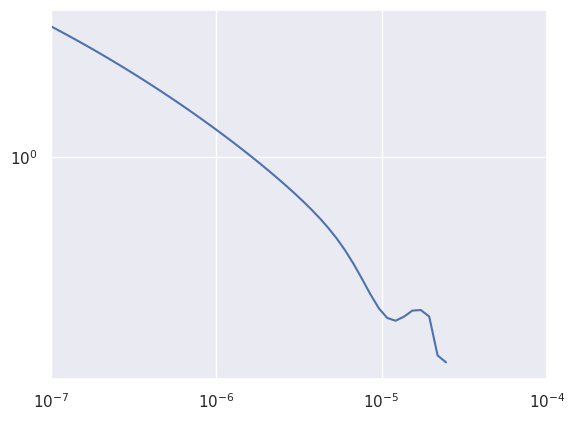

In [45]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(lrs), np.max(lrs)])

## Fit with PyTorch

In [53]:
import torch
import math

In [54]:
from itertools import chain

def pytorch_fit(x, y, criterion, make_optim_fn, n_epochs=100):
  # convert numpy arrays to torch tensors
  x = torch.as_tensor(x)
  y = torch.as_tensor(y)
  dim = x.shape[1]
  dtype = x.dtype

  # define initial w to be the zero vector
  w_fit = torch.nn.Parameter(torch.zeros(dim, dtype=dtype))
  criterion.initialize(x @ w_fit, y)

  # create optimizer
  parameters_to_learn = chain(criterion.parameters(), [w_fit])
  optim = make_optim_fn(parameters_to_learn)

  # regular PyTorch training loop.
  for epoch in range(n_epochs):
    for xi, yi in zip(x, y):
      pred = torch.dot(xi, w_fit)
      loss = criterion(pred, yi)

      optim.zero_grad()
      loss.backward()
      optim.step()

  return w_fit.detach()

In [55]:
class StrippedTiltedLoss(torch.nn.Module):
  def __init__(self, underlying_loss, t):
    super().__init__()
    self.underlying_loss = underlying_loss
    self.t = t

  def initialize(self, x, y):
    pass

  def forward(self, pred, target):
    return torch.exp(self.t * self.underlying_loss(pred, target))


class VariationalTiltedLoss(torch.nn.Module):
  def __init__(self, underlying_loss, t):
    super().__init__()
    self.t = t
    self.underlying_loss = underlying_loss
    self.v = torch.nn.Parameter(torch.tensor(0.))

  def initialize(self, preds, targets):
    with torch.no_grad():
      init_losses = self.underlying_loss(preds, targets)
      n = init_losses.shape[0]

      v_init = -torch.logsumexp(self.t * init_losses - math.log(n), dim=-1)
      self.v.set_(v_init.to(self.v.dtype))

  def forward(self, pred, target):
    sample_loss = self.underlying_loss(pred, target)
    return torch.exp(self.t * sample_loss + self.v) - self.v

In [56]:
from functools import partial
from itertools import product
import pandas as pd

def compare_tilted_formulations(x, y, ts, lrs, optim_ctor):
  records = []
  for t, lr in tqdm(list(product(ts, lrs))):
      make_optim_fn = partial(optim_ctor, lr=lr)

      mse_loss = MSELoss(reduction='none')
      w_exp_fit = pytorch_fit(x, y, StrippedTiltedLoss(mse_loss, t), make_optim_fn)
      w_tilted_fit = pytorch_fit(x, y, VariationalTiltedLoss(mse_loss, t), make_optim_fn)

      w_exp_loss = compute_tilted_loss(w_exp_fit, x, y, t).item()
      w_tilted_loss = compute_tilted_loss(w_tilted_fit, x, y, t).item()
      records.append(dict(t=t, lr=lr, loss_type='stripped', value=w_exp_loss))
      records.append(dict(t=t, lr=lr, loss_type='variational', value=w_tilted_loss))

  return pd.DataFrame.from_records(records)

In [57]:
sgd_lrs = np.geomspace(1e-7, 1e-1, 30).tolist()
ts = [0.5, 1, 2]

sgd_eval_recs = compare_tilted_formulations(x, y, ts=ts, lrs=sgd_lrs, optim_ctor=torch.optim.SGD)

  0%|          | 0/90 [00:00<?, ?it/s]

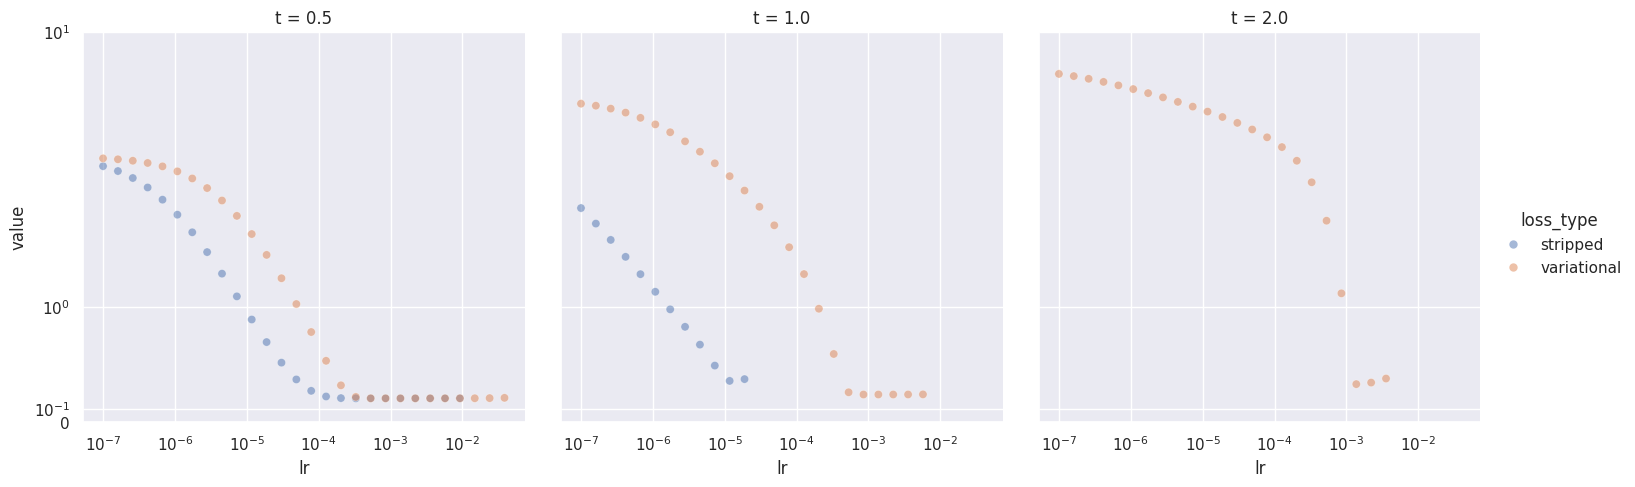

In [58]:
import seaborn as sns
sns.set()

g = sns.relplot(data=sgd_eval_recs,
                hue='loss_type', col='t', x='lr', y='value', alpha=0.5)
g.set(xscale='log')
g.set(ylim=[0, 10])
g.set(yscale='asinh')

In [59]:
adam_lrs = np.geomspace(1e-5, 1e2, 30)
adam_eval_recs = compare_tilted_formulations(x, y, ts=ts, lrs=adam_lrs, optim_ctor=torch.optim.Adam)

  0%|          | 0/90 [00:00<?, ?it/s]

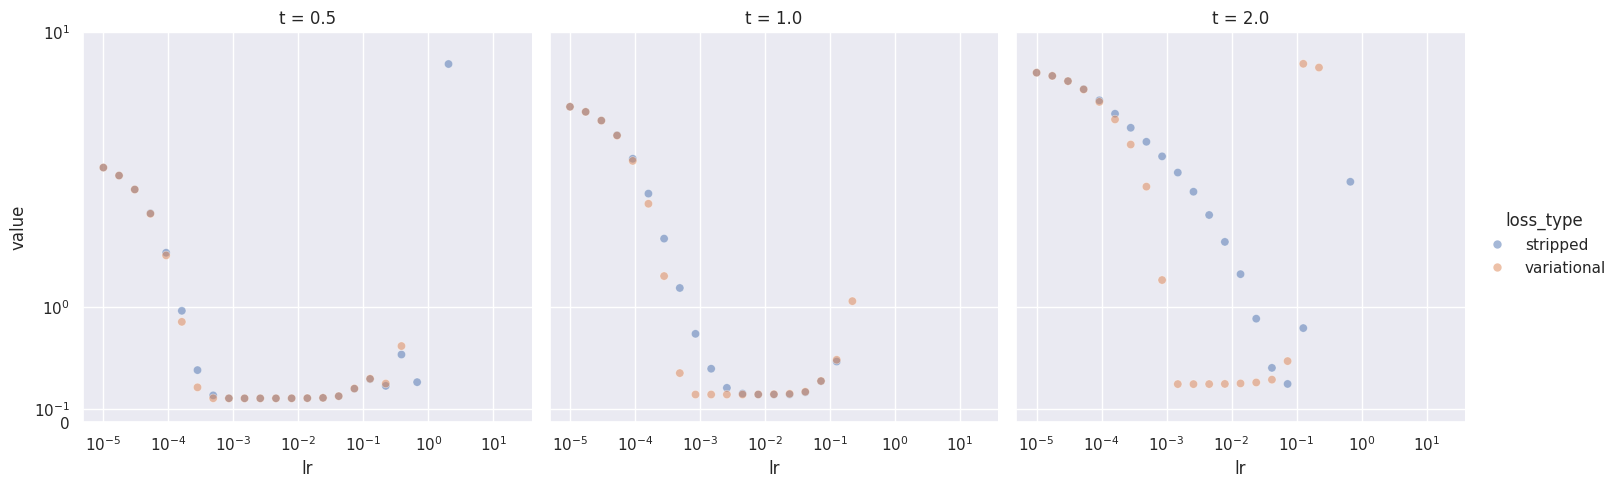

In [60]:
g = sns.relplot(data=adam_eval_recs,
                hue='loss_type', col='t', x='lr', y='value', alpha=0.5)
g.set(xscale='log')
g.set(ylim=[0, 10])
g.set(yscale='asinh')

In [61]:
sgd_eval_recs.groupby(['loss_type', 't']).agg({'value': 'min'})

value
loss_type   t            
stripped    0.5  0.179521
            1.0  0.317836
            2.0       NaN
variational 0.5  0.179521
            1.0  0.209373
            2.0  0.291620

In [62]:
adam_eval_recs.groupby(['loss_type', 't']).agg({'value': 'min'})

value
loss_type   t            
stripped    0.5  0.179530
            1.0  0.209426
            2.0  0.293253
variational 0.5  0.179524
            1.0  0.209382
            2.0  0.291761